## Mean-Variance Optimization with risky asset and cash

In [595]:
# import warnings
# warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import scipy
from scipy.stats import norm
import random
import time
import matplotlib.pyplot as plt
import bspline
import bspline.splinelab as splinelab

## Parameters for MC simulation of stock prices

In [145]:
S0 = 100      # initial stock price
mu = 0.03 # 0.012 # 0.05     # drift
sigma = 0.20 # / np.sqrt(365) # 0.15  # volatility
r = 0.01      # risk-free rate

M = 1 # 30 # 1               # maturity
T = 30 # 24 # 12         # number of time steps

N_MC = 2000 # 2000 # 10000 # 50000   # number of paths

delta_t = M / T                # time interval
gamma = np.exp(- r * delta_t)  # discount factor
lmbda = 10.0
alpha=1.0


Time Cost: 0.0671541690826416 seconds


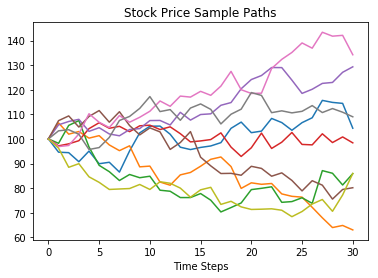

In [146]:
# make dataset

starttime = time.time()

# stock price
S = pd.DataFrame([], index=range(1, N_MC+1), columns=range(T+1))
S.loc[:,0] = S0


# standard normal random numbers
RN = pd.DataFrame(np.random.randn(N_MC,T), index=range(1, N_MC+1), columns=range(1, T+1))

for t in range(1, T+1):
    S.loc[:,t] = S.loc[:,t-1] * np.exp((mu - 1/2 * sigma**2) * delta_t + sigma * np.sqrt(delta_t) * RN.loc[:,t])
    # Or using Euler for alpha-stable distributions
    #S.loc[:,t] = S.loc[:,t-1]*(1+ mu*delta_t + sigma *S.loc[:,t-1]**(alpha-1)*np.sqrt(delta_t) * RN.loc[:,t])
  

endtime = time.time()
print('\nTime Cost:', endtime - starttime, 'seconds')

# plot 10 paths
step_size = N_MC // 10
idx_plot = np.arange(step_size, N_MC, step_size)
plt.plot(S.T.iloc[:, idx_plot])
plt.xlabel('Time Steps')
plt.title('Stock Price Sample Paths')
plt.show()


$$C_t = -R_t= -r_t  + \lambda (r_t-\mu)^2  =  -(1-u_t)r_f - u_t  \phi_t  +  \lambda u_t^2 Var(\phi_t | S_t)$$ 

In [6]:
def negative_reward(mu, var, a, rf, lmbda):
    
    C = -(1-a)*rf - a*mu + lmbda*(a**2)*var
    return C

##  Define spline basis functions  

In [638]:
# set the wealth (but not the total wealth) of the portfolio to be the stock price
X=S
p = 4              # order of spline (as-is; 3 = cubic, 4: B-spline?)
ncolloc = 16
a_min = -1
a_max = 1

X.shape =  (2000, 31)
X_min, X_max =  38.849942383289964 205.57711656436646


In [600]:
def get_basis_functions(X_min, X_max, a_min, a_max, ncolloc, p=3):
    tau_x = np.linspace(X_min,X_max,ncolloc)  # These are the sites to which we would like to interpolate
    tau_a = np.linspace(a_min,a_max,ncolloc)  # These are the sites to which we would like to interpolate

    # k is a knot vector that adds endpoints repeats as appropriate for a spline of order p
    # To get meaninful results, one should have ncolloc >= p+1
    k_x = splinelab.aptknt(tau_x, p) 
    k_a = splinelab.aptknt(tau_a, p) 
                             
    # Spline basis of order p on knots k
    basis_x = bspline.Bspline(k_x, p)        
    basis_a = bspline.Bspline(k_a, p)        
    return basis_x, basis_a
    #f = plt.figure()

    # B   = bspline.Bspline(k, p)     # Spline basis functions 
    #print('Number of points k_x = ', len(k_x))
    #basis_x.plot()
    #print('Number of points k_a = ', len(k_a))
    #basis_a.plot()

    #plt.savefig('Basis_functions.png', dpi=600)

### Make data matrices with feature values

"Features" here are the values of basis functions at data points
The outputs are 3D arrays of dimensions num_tSteps x num_MC x num_basis

In [643]:
num_t_steps = T + 1
num_basis =  ncolloc**2 # len(k) #

data_mat_t = np.zeros((num_t_steps, N_MC, num_basis ))

In [567]:
x=X.values[:,0]
np.shape(x)

(2000,)

## Compute the optimal Q-function with the DP approach 

Coefficients for expansions of the optimal Q-function $Q_t^\star\left(X_t,a_t^\star\right)$ are solved by

$$W_t=\mathbf S_t^{-1}\mathbf M_t$$

where $\mathbf S_t$ and $\mathbf M_t$ are matrix and vector respectively with elements given by

$$S_{nm}^{\left(t\right)}=\sum_{k=1}^{N_{MC}}{\Phi_n\left(X_t^k,a_t^k\right)\Phi_m\left(X_t^k,a_t^k\right)}\quad\quad M_n^{\left(t\right)}=\sum_{k=1}^{N_{MC}}{\Phi_n\left(X_t^k,a_t^k\right)\left(C\left(X_t^k,a_t^k,X_{t+1}^k\right)+\gamma\min_{a_{t+1}\in\mathcal{A}}Q_{t+1}^\star\left(X_{t+1}^k,a_{t+1}^k\right)\right)}$$

Define function *function_S* and *function_M* to compute the value of matrix $\mathbf S_t$ and vector $\mathbf M_t$.

In [771]:
def function_S_vec(t,data_mat_t):
    # Compute the matrix S_{nm} 
    X_mat = data_mat_t[t,:,:]
    num_basis_funcs = X_mat.shape[1]    
    S_mat = np.dot(X_mat.T, X_mat)# + reg_param * np.eye(num_basis_funcs)
    return S_mat

def function_M_vec(t, Q, R, data_mat_t, gamma=0.1):
    X_mat = data_mat_t[t,:,:]
    tmp = R + gamma * np.min(Q[:,t+1])  # note that the second argument in Q is t+1 !
    M = np.dot(X_mat.T, tmp)
    return M

### Least Squares Policy Iteration
Call *function_S* and *function_M* for $t=T-1,...,0$ together with basis function $\Phi_n\left(X_t,a_t\right)$ to compute optimal action Q-function $Q_t^\star\left(X_t,a_t^\star\right)=\sum_n^N{\omega_{nt}\Phi_n\left(X_t,a_t^\star\right)}$ backward recursively with terminal condition $Q_T^\star\left(X_T,a_T=0\right)=0$.



# initialize datastructures

In [772]:
starttime = time.time()

mu = np.zeros(T)
var= np.zeros(T)
# optimal action
a_opt = np.zeros((N_MC,T))
a_star = pd.DataFrame([], index=range(1, N_MC+1), columns=range(T+1))
a_star.iloc[:,-1] = 0

# optimal Q-function with optimal action

max_Q_star = np.zeros((N_MC,T))
#num_basis = data_mat_t.shape[2]
a_mean = []

#### initialize actions in feasible region [0,a_max]

In [645]:
grid_size_x=20
grid_size_a=500 
# set up a small grid, sufficiently nested inside the support of the basis functions
a_min_prime=a_min+0.1
a_max_prime =a_max-0.1
a_grid=np.linspace(a_min_prime,a_max_prime,grid_size_a)

There are grid_size_x $\times$ grid_size_a inner grid points and 256 basis functions. Let $(k,l)$ denote the indices of the smaller grid $\Omega^h$. Let $(i,j)$ denote the indices of the knot points of the basis functions. If you sum over the last index, then you can check the interpolation of ones
$$f(x_k,a_l)=\sum_{ij} \Phi(x_k,a_l)f_{ij}$$
check if $f_{ij}=1$ everywhere
$$f(x,a)=\sum_{ij} \Phi(x,a)1 =1, \forall x,a ?$$

In [829]:
# The backward loop: make sure to rerun cell with heading 'initialing data structures'
# and reset the data structures before running this cell
Q_star = np.zeros((N_MC,T))
tau = 1e-6

In [830]:
a=a_min_prime+ (a_max_prime-a_min_prime)*np.random.rand(N_MC)

In [831]:
for t in np.arange(T-2,0,-1):
  error = tau
  q_prev = np.zeros(N_MC)  
  #q_prev = np.zeros(grid_size_x*grid_size_a).reshape(grid_size_a, grid_size_x)  
  
  #a=a_star_exact*np.ones(N_MC)  
  ret = (S.loc[:,t+1]- S.loc[:,t])/S.loc[:,t]
  mu[t] = np.mean(ret)
  var[t]=np.var(ret)
  count =0
  max_iter=100
  x = X.values[:,t] #S.loc[:,t]
  basis_x, basis_a=get_basis_functions(np.min(x)-10, np.max(x)+10, a_min, a_max, ncolloc, p)
  x_grid=np.linspace(np.min(x), np.max(x),grid_size_x)
  Phi_mat=np.array([[np.kron(basis_x(x_grid[i]),basis_a(a_grid[j])).reshape(num_basis,1) for i in range(grid_size_x)] for j in range(grid_size_a)])[:,:,:,0]   
      
  while (np.abs(error)>=tau) and (count<max_iter):
   
    R=negative_reward(mu[t], var[t], a, r, lmbda)
    data_mat_t[t,:,:] = np.array([np.kron(basis_x(x[i]),basis_a(a[i])).reshape(num_basis,1) for i in range(N_MC)])[:,:,0]
    # check partition of unity
    h=np.dot(data_mat_t[t],np.ones(np.shape(data_mat_t[t])[1]))
    if np.sum(h)!=N_MC:
        print("error: loss of partition of unity")
    S_t = function_S_vec(t,data_mat_t) 
    M_t = function_M_vec(t, Q_star, R, data_mat_t, gamma)
    W_t = np.dot(np.linalg.pinv(S_t),M_t)
    # Q_t_pi_full= np.dot(data_mat_t[t], W_t)
    # compute Q_t matrix over small grid
    # Phi_mat is the matrix for interpolating over the smaller  x \times a grid
    Q_t = np.dot(Phi_mat, W_t) # gridded Q_t
    print("residual error: ||r||=||Sw-M||")
    print(np.linalg.norm(np.dot(S_t, W_t)-M_t))
    
    # find the optimal action on the small grid
    a_idx=  np.argmin(Q_t, axis=0)
    #need to interpolate over X 
    a_star_= np.array([0]*grid_size_x, dtype='float64')
    
    for j in range(grid_size_x):
        a_star_[j]=a_grid[a_idx[j]]

    f=scipy.interpolate.interp1d(x_grid, a_star_, kind='cubic')
    a_prime=f(x)
    # only update the actions along the paths where the neg. reward is lowered
    R_prime=negative_reward(mu[t], var[t], a_prime, r, lmbda)
    idx=np.where(R_prime>R)
    a_prime[idx]=a[idx]
    a=a_prime
    a_mean.append(np.mean(a))
    Q_star[:,t]=np.dot(data_mat_t[t,:,:], W_t)
    error=np.linalg.norm(Q_star[:,t]-q_prev)
    #error=np.linalg.norm(Q_t-q_prev)
    
    #q_prev=Q_t
    q_prev=np.copy(Q_star[:,t])
    print('count, Q error, E[R], E[a]')
    print(count, error, np.mean(R), np.mean(a))
    count+=1
   
  a_opt[:,t]=a  

residual error: ||r||=||Sw-M||
2.938374884306035e-08
count, Q error, E[R], E[a]
0 0.38733548145452085 -0.006491916628837665 -0.344869371212577
residual error: ||r||=||Sw-M||
0.0035726591015551048
count, Q error, E[R], E[a]
1 0.34240195316971667 -0.01156190017184145 -0.34470329334524474
residual error: ||r||=||Sw-M||
0.001346630095586755
count, Q error, E[R], E[a]
2 0.00109524025704787 -0.011562724121494958 -0.34463469386445106
residual error: ||r||=||Sw-M||
0.0012922060882914893
count, Q error, E[R], E[a]
3 0.0004057352343094652 -0.011562988286418604 -0.3446360164818246
residual error: ||r||=||Sw-M||
0.003296392475786091
count, Q error, E[R], E[a]
4 0.00027467089735060465 -0.011563057762631938 -0.3446312574700704
residual error: ||r||=||Sw-M||
0.002713723765657943
count, Q error, E[R], E[a]
5 0.0004124496651090255 -0.011563081378365479 -0.3446126781713019
residual error: ||r||=||Sw-M||
0.005432217165658992
count, Q error, E[R], E[a]
6 0.0006591173297835493 -0.01156310625787107 -0.34460

residual error: ||r||=||Sw-M||
0.0045297354422482354
count, Q error, E[R], E[a]
57 0.00031890887838498613 -0.011563117014374047 -0.3447301895155902
residual error: ||r||=||Sw-M||
0.004291205576583551
count, Q error, E[R], E[a]
58 0.0006221918434703727 -0.011563117014518263 -0.3447301888716391
residual error: ||r||=||Sw-M||
0.0029734754205620476
count, Q error, E[R], E[a]
59 0.0002614704391250449 -0.011563117014523318 -0.3447300066690065
residual error: ||r||=||Sw-M||
0.004704147831719294
count, Q error, E[R], E[a]
60 0.000534150897094394 -0.011563117014814824 -0.344730218300638
residual error: ||r||=||Sw-M||
0.0033691179750250703
count, Q error, E[R], E[a]
61 0.0006938596107493065 -0.011563117017641797 -0.34473179399771947
residual error: ||r||=||Sw-M||
0.005964724278721671
count, Q error, E[R], E[a]
62 0.0005461209202858138 -0.011563117020871413 -0.34473249526403704
residual error: ||r||=||Sw-M||
0.004085316972072564
count, Q error, E[R], E[a]
63 0.000976920258045302 -0.01156311702278

residual error: ||r||=||Sw-M||
0.017996781467684787
count, Q error, E[R], E[a]
21 0.0012974702940337648 -0.011163031162489094 -0.2878079965164684
residual error: ||r||=||Sw-M||
0.01128522629868561
count, Q error, E[R], E[a]
22 0.0012150640585761397 -0.01116303140294409 -0.2878536448707509
residual error: ||r||=||Sw-M||
0.006321064629707236
count, Q error, E[R], E[a]
23 0.0013722193514288006 -0.011163032408529438 -0.28783063754484123
residual error: ||r||=||Sw-M||
0.004865861755714523
count, Q error, E[R], E[a]
24 0.0010241337644746574 -0.011163032744479903 -0.2878316954058581
residual error: ||r||=||Sw-M||
0.0153653877908588
count, Q error, E[R], E[a]
25 0.00176213714028537 -0.011163032753906304 -0.28785248597287943
residual error: ||r||=||Sw-M||
0.005650217124183394
count, Q error, E[R], E[a]
26 0.002115723492052396 -0.011163032906923956 -0.28786350743756356
residual error: ||r||=||Sw-M||
0.004810762730557034
count, Q error, E[R], E[a]
27 0.000753897701649777 -0.01116303323915353 -0.2

residual error: ||r||=||Sw-M||
0.005532240972692544
count, Q error, E[R], E[a]
17 0.001416932665497775 -0.011993450793879553 -0.3812763177577096
residual error: ||r||=||Sw-M||
0.006741886230458551
count, Q error, E[R], E[a]
18 0.001277671644919953 -0.011993450896477794 -0.38128822220692815
residual error: ||r||=||Sw-M||
0.03183915684313377
count, Q error, E[R], E[a]
19 0.00279808715969752 -0.011993451306044171 -0.3812908661132317
residual error: ||r||=||Sw-M||
0.01098824339986181
count, Q error, E[R], E[a]
20 0.003981100330489758 -0.011993451322706716 -0.38130290501212677
residual error: ||r||=||Sw-M||
0.0055325145317442
count, Q error, E[R], E[a]
21 0.0014683640668471415 -0.01199345146921044 -0.38131061450796355
residual error: ||r||=||Sw-M||
0.030684225483236238
count, Q error, E[R], E[a]
22 0.0033278862099618014 -0.011993451570851838 -0.38132103995956346
residual error: ||r||=||Sw-M||
0.01089947891523986
count, Q error, E[R], E[a]
23 0.0038265494646107295 -0.01199345166998369 -0.381

residual error: ||r||=||Sw-M||
0.004163558121651222
count, Q error, E[R], E[a]
3 0.007226079269251393 -0.011360283229155265 -0.3286670916094533
residual error: ||r||=||Sw-M||
0.0060850919175885546
count, Q error, E[R], E[a]
4 0.0005168474640545323 -0.011360284438055672 -0.3280849794304859
residual error: ||r||=||Sw-M||
0.0001741555512152815
count, Q error, E[R], E[a]
5 0.0006018050844414656 -0.011360302846481605 -0.32768397853471165
residual error: ||r||=||Sw-M||
0.0022908804058837354
count, Q error, E[R], E[a]
6 0.0005030947917816137 -0.011360309275017286 -0.3272768443216827
residual error: ||r||=||Sw-M||
8.032949784868129e-05
count, Q error, E[R], E[a]
7 0.000529109241486875 -0.011360325736233325 -0.32688547827160874
residual error: ||r||=||Sw-M||
3.690497817674851e-05
count, Q error, E[R], E[a]
8 1.0983921377818066e-05 -0.01136033679252922 -0.32688547827160874
residual error: ||r||=||Sw-M||
3.690497817674851e-05
count, Q error, E[R], E[a]
9 0.0 -0.01136033679252922 -0.32688547827160

residual error: ||r||=||Sw-M||
0.0040262243177289795
count, Q error, E[R], E[a]
7 0.0011196047007774213 -0.011336093608382693 -0.3176292865864102
residual error: ||r||=||Sw-M||
0.011120005249068223
count, Q error, E[R], E[a]
8 0.0011622643977979902 -0.011336096765401553 -0.31762520181642817
residual error: ||r||=||Sw-M||
0.010095290799616468
count, Q error, E[R], E[a]
9 0.0009769738675816338 -0.011336096973575741 -0.3175862455782634
residual error: ||r||=||Sw-M||
0.004889957094852242
count, Q error, E[R], E[a]
10 0.0009651408596869695 -0.01133610165323676 -0.31751216126084225
residual error: ||r||=||Sw-M||
0.007850027602374982
count, Q error, E[R], E[a]
11 0.00032837229809664693 -0.01133610468327861 -0.3174851594818905
residual error: ||r||=||Sw-M||
0.015386557905378346
count, Q error, E[R], E[a]
12 0.0016850527234521285 -0.011336105161507879 -0.31755168967236996
residual error: ||r||=||Sw-M||
0.005016978586650732
count, Q error, E[R], E[a]
13 0.0014620025928358607 -0.01133610674301772

residual error: ||r||=||Sw-M||
0.0018954636382137883
count, Q error, E[R], E[a]
2 0.000860978165669069 -0.011395528785978187 -0.3233772655460565
residual error: ||r||=||Sw-M||
0.0035853368741601945
count, Q error, E[R], E[a]
3 0.00043604197468142636 -0.011395640612806065 -0.3232548591539769
residual error: ||r||=||Sw-M||
0.008121575061437165
count, Q error, E[R], E[a]
4 0.0006293512498839191 -0.011395655745784355 -0.3231677913521742
residual error: ||r||=||Sw-M||
0.0021299615644503247
count, Q error, E[R], E[a]
5 0.000826784368052905 -0.011395657726141139 -0.32288769881347384
residual error: ||r||=||Sw-M||
0.002465154762485539
count, Q error, E[R], E[a]
6 0.0004400108791274299 -0.01139566952109221 -0.3230192100614552
residual error: ||r||=||Sw-M||
0.0005502845533273712
count, Q error, E[R], E[a]
7 0.0003566027067290133 -0.011395670125814727 -0.3229329263909267
residual error: ||r||=||Sw-M||
0.00043433834644727987
count, Q error, E[R], E[a]
8 8.290772080567812e-05 -0.0113956791874717 -0

residual error: ||r||=||Sw-M||
0.026415279726138437
count, Q error, E[R], E[a]
26 0.0055229719068689434 -0.01114688888820497 -0.2834269791988542
residual error: ||r||=||Sw-M||
0.058519116793155974
count, Q error, E[R], E[a]
27 0.007521031196563498 -0.011146888900537886 -0.2834672993980635
residual error: ||r||=||Sw-M||
0.013853103889221981
count, Q error, E[R], E[a]
28 0.005965136261701305 -0.011146889297357895 -0.283464204490332
residual error: ||r||=||Sw-M||
0.07570083540955708
count, Q error, E[R], E[a]
29 0.0071370404723380305 -0.01114688939548609 -0.28347890745889753
residual error: ||r||=||Sw-M||
0.05281001173917147
count, Q error, E[R], E[a]
30 0.006661877529563759 -0.011146889549640082 -0.28347890745889753
residual error: ||r||=||Sw-M||
0.05281001173917147
count, Q error, E[R], E[a]
31 0.0 -0.011146889549640082 -0.28347890745889753
residual error: ||r||=||Sw-M||
0.01214045126140409
count, Q error, E[R], E[a]
0 9.751411341338864 -0.01151158915799677 -0.31464166989408443
residual

residual error: ||r||=||Sw-M||
0.000578125072553705
count, Q error, E[R], E[a]
5 0.0006119926864151106 -0.011416163549775163 -0.32025343741612117
residual error: ||r||=||Sw-M||
0.0055705259030971845
count, Q error, E[R], E[a]
6 0.0006176726941124521 -0.011417609402085596 -0.3203380858185778
residual error: ||r||=||Sw-M||
0.012938062518845361
count, Q error, E[R], E[a]
7 0.0013726744849885911 -0.011417646696201041 -0.32036525964554136
residual error: ||r||=||Sw-M||
0.006495650156975198
count, Q error, E[R], E[a]
8 0.0014529820505969004 -0.011417647763910035 -0.32018324009220134
residual error: ||r||=||Sw-M||
0.0250092044189397
count, Q error, E[R], E[a]
9 0.00252896488261502 -0.011417662459680728 -0.32023085483672753
residual error: ||r||=||Sw-M||
0.030523643650906224
count, Q error, E[R], E[a]
10 0.0010230547781444014 -0.01141766326522588 -0.3202434724175822
residual error: ||r||=||Sw-M||
0.047775043752961335
count, Q error, E[R], E[a]
11 0.006901172384926237 -0.01141766448044235 -0.32

residual error: ||r||=||Sw-M||
0.02381450474307614
count, Q error, E[R], E[a]
39 0.005651005287580235 -0.010951639910265237 -0.25812839589404873
residual error: ||r||=||Sw-M||
0.05962399496733013
count, Q error, E[R], E[a]
40 0.0062032670080379645 -0.010951639913335259 -0.25811852829892834
residual error: ||r||=||Sw-M||
0.09341678802092032
count, Q error, E[R], E[a]
41 0.014845662270093225 -0.01095164025254022 -0.2581244255238228
residual error: ||r||=||Sw-M||
0.060872463200619085
count, Q error, E[R], E[a]
42 0.006702732690748288 -0.010951640277912759 -0.258131940610403
residual error: ||r||=||Sw-M||
0.06630100103547472
count, Q error, E[R], E[a]
43 0.006026281157331912 -0.010951640396308483 -0.2581317425839928
residual error: ||r||=||Sw-M||
0.13785707832683772
count, Q error, E[R], E[a]
44 0.017890533092257174 -0.010951640499271411 -0.25813249481130873
residual error: ||r||=||Sw-M||
0.12388448601225147
count, Q error, E[R], E[a]
45 0.023982313643940944 -0.010951640508441772 -0.258117

residual error: ||r||=||Sw-M||
0.0030097436204406243
count, Q error, E[R], E[a]
16 0.00046560674258855665 -0.01175474538060849 -0.3559677400400007
residual error: ||r||=||Sw-M||
0.004096634686135048
count, Q error, E[R], E[a]
17 0.000586909538392081 -0.011754746157545376 -0.35600142450409294
residual error: ||r||=||Sw-M||
0.015808855092898783
count, Q error, E[R], E[a]
18 0.0016927603126693578 -0.011754747868942641 -0.35600683066869
residual error: ||r||=||Sw-M||
0.0069822408638152275
count, Q error, E[R], E[a]
19 0.0020106079217883897 -0.011754747990057785 -0.3560630679417311
residual error: ||r||=||Sw-M||
0.0029824930987108083
count, Q error, E[R], E[a]
20 0.0014817207236399756 -0.011754748617818056 -0.3560668720644746
residual error: ||r||=||Sw-M||
0.004641238459674286
count, Q error, E[R], E[a]
21 0.0011255644296063524 -0.01175474871453352 -0.35606722167293664
residual error: ||r||=||Sw-M||
0.007070199336799187
count, Q error, E[R], E[a]
22 0.0006224430908409011 -0.0117547487150204

0.023953975335681173
count, Q error, E[R], E[a]
9 0.0031319282816395346 -0.011201993770434626 -0.2939599548904505
residual error: ||r||=||Sw-M||
0.02943379700905376
count, Q error, E[R], E[a]
10 0.001424677641252545 -0.011202004745204863 -0.29398981959581316
residual error: ||r||=||Sw-M||
0.009742982463479533
count, Q error, E[R], E[a]
11 0.0017858424084828393 -0.011202005283759323 -0.29414325393444746
residual error: ||r||=||Sw-M||
0.05092009974041993
count, Q error, E[R], E[a]
12 0.00524337144942608 -0.01120203769068153 -0.2941732675075648
residual error: ||r||=||Sw-M||
0.01947221068641349
count, Q error, E[R], E[a]
13 0.004825950071276467 -0.011202039034564407 -0.29430366354119714
residual error: ||r||=||Sw-M||
0.0432123786941879
count, Q error, E[R], E[a]
14 0.0031070832202968217 -0.011202042331530111 -0.2943283245084627
residual error: ||r||=||Sw-M||
0.017301727432251113
count, Q error, E[R], E[a]
15 0.00523421709440628 -0.011202044001944729 -0.2943218731491561
residual error: ||r

In [834]:
a_star_exact=[]
a_star_approx=[]
for t in range(1, T-1):
    a_star_exact.append((mu[t]-r)/(2*lmbda*var[t]))
    a_star_approx.append(np.mean(a_opt[:,t]))

Text(0,0.5,'action')

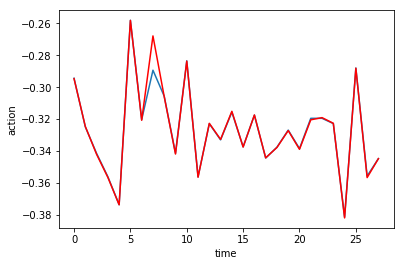

In [835]:
plt.plot(a_star_approx)
plt.plot(a_star_exact, color='red')
plt.xlabel('time')
plt.ylabel('action')

In [805]:
a_star_exact=(mu[t]-r)/(2*lmbda*var[t])

In [806]:
a_star_exact

-0.3377513594678937

In [807]:
negative_reward(mu[t], var[t], a_star_exact, r, lmbda)

-0.011525543421673185

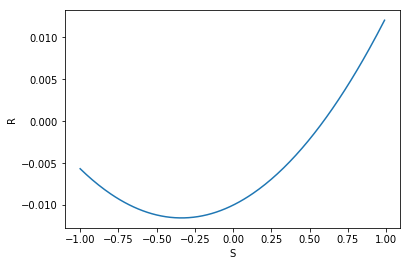

In [808]:
a_=np.arange(-1,1,0.01)
plt.plot(a_,negative_reward(mu[t], var[t], a_, r, lmbda))
plt.xlabel('S')
plt.ylabel('R')
plt.show()

(-1, 1)

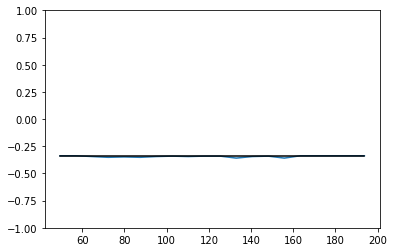

In [809]:
#plt.plot(a_mean)
plt.plot(x_grid, a_star_)
plt.plot(x_grid,np.ones(len(x_grid))*a_star_exact, color='black')
plt.ylim([-1,1])

optimal action depends on lambda